# Running HMETS using CANOPEX Meteorological and hydrologic data data

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We do this by using the extended Canada-USA CANOPEX database to provide hydromet data and catchment properties to drive the RAVEN models.

In [58]:
from birdy import WPSClient
import time
from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc
from zipfile import ZipFile
import glob
import pandas as pd

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
# url="http://localhost:9099" 

wps = WPSClient(url)

# DATA MAIN SOURCE
CANOPEX='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc'

# This line is to transform units to Raven's expected format.
nc_transform=json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})

In [59]:
# Controls
start=dt.datetime(1998, 1, 1)
stop = dt.datetime(2010, 12, 31)
calibration_evaluation_budget = 10
calibration_algorithm='DDS'
# Comment out the random seed to show different results!
random_seed=6.67408*10**-11,
watershedID=1500 # From 0 to 5796


In [60]:
# SECTION TO SEPARATE DISCHARGE AND MET DATA TO TEST IF A USER HAS DIFFERENT DATASETS
filepathMet = os.getcwd()+"/CANOPEX_subset.nc"
filepathQobs=os.getcwd()+"/CANOPEX_Qobs.nc"

basindata=xr.open_dataset(CANOPEX)
basinName=basindata['watershed'][watershedID]
newBasin=basindata.isel(watershed=watershedID)
basin_area=newBasin['drainage_area'].item(0)

Qobsfile = newBasin['discharge']
Qobsfile.to_netcdf(filepathQobs)
D = nc.Dataset(filepathQobs, mode="a")
D.variables["time"].units += " 00:00:00"
D.close()

newBasin=newBasin[['drainage_area','pr','tasmax','tasmin']]
newBasin.to_netcdf(filepathMet)
D = nc.Dataset(filepathMet, mode="a")
D.variables["time"].units += " 00:00:00"
D.close()

<xarray.DataArray 'tasmax' (time: 22280)>
array([282.342647, 284.279118, 289.247059, ..., 273.817353, 279.266471,
       284.807941])
Coordinates:
    watershed  |S64 ...
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2010-12-31
Attributes:
    units:                  K
    coverage_content_type:  modelResult
    long_name:              Daily Maximum Near-Surface Air Temperature
    standard_name:          air_temperature
    _ChunkSizes:            [ 363 1393]


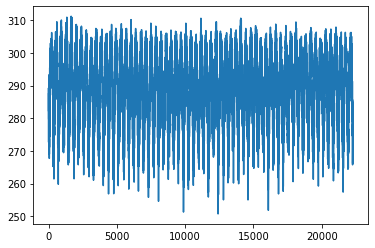

In [61]:
# UNCOMMENT FOR QUICK PLOT OF DATA
ds=xr.open_dataset(filepathMet)
print(ds['tasmax'])
plt.plot(ds['tasmax'])
plt.show()
ds.close()

In [62]:
# Dirty fix for testing only. We already have this info in the regionalization DB. Perhaps we can add it to the NetCDF?
# Else we can simply read from the csv.
tmp=pd.read_csv(TESTDATA['regionalizationDB'])
basin_latitude = tmp['latitude'][watershedID]
basin_longitude = tmp['longitude'][watershedID]
basin_elevation = tmp['elevation'][watershedID]
print(basin_latitude)

40.08624903070456


In [74]:
import time
# The model parameter boundaries. Can either be a string of comma separated values, a list, an array or a named tuple. 
lowerBounds = '0.3, 0.01, 0.5, 0.15, 0.0, 0.0, -2.0, 0.01, 0.0, 0.01, 0.005, -5.0, 0.0, 0.0, 0.0, 0.0, 0.00001, 0.0, 0.00001, 0.0, 0.0'
upperBounds = '20.0, 5.0, 13.0, 1.5, 20.0, 20.0, 3.0, 0.2, 0.1, 0.3, 0.1, 2.0, 5.0, 1.0, 3.0, 1.0, 0.02, 0.1, 0.01, 0.5, 2.0'
          
# OSTRICH configuration parameters
config = dict(
    algorithm=calibration_algorithm, random_seed=random_seed, max_iterations=calibration_evaluation_budget, area=basin_area,
    elevation=basin_elevation, latitude=basin_latitude, longitude=basin_longitude, lowerbounds=lowerBounds,
    upperbounds=upperBounds, start_date=start, end_date=stop, suppress_output=True,
    rain_snow_fraction='RAINSNOW_DINGMAN', nc_spec=nc_transform 
    )

# Let's call Ostrich with the timeseries, calibration parameters and other configuration parameters
tic = time.perf_counter()
resp = wps.ostrich_hmets(ts=[str(filepathMet),str(filepathQobs)], **config)
toc = time.perf_counter()
print("Time:  " + str(toc-tic))

Time:  7.130211316049099


In [75]:
# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[calibration, hydrograph, storage, solution, diagnostics, calibparams, rv] = resp.get(asobj=True)

In [79]:
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = str(calibparams)#'9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
           # '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'


# Model configuration parameters
config = dict(
    start_date=start,
    end_date=stop,
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name='test_hmets_CANOPEX',
    rain_snow_fraction='RAINSNOW_DINGMAN',
    nc_spec=nc_transform,  
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=[str(filepathMet),str(filepathQobs)], params=params, **config)


In [80]:

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [81]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_asma0cd_/CANOPEX_Qobs.nc,0.594227,58.8081,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [82]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 4748, nbasins: 1)>
array([[  0.      ],
       [201.071169],
       [390.313088],
       ...,
       [ 47.902295],
       [ 45.67655 ],
       [ 70.693847]])
Coordinates:
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2010-12-31
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

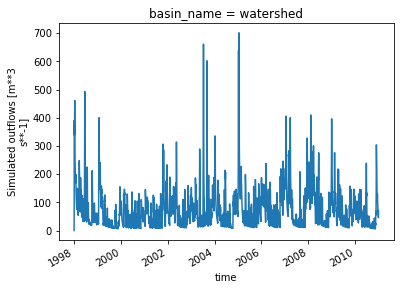

In [83]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [84]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(701.32894938)
Mean:  <xarray.DataArray 'q_sim' ()>
array(75.0823244)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[136.15580988],
       [109.0782069 ],
       [ 99.43221307],
       [ 72.26515655],
       [ 62.62604562],
       [ 63.93322478],
       [ 47.39367192],
       [ 33.93483848],
       [ 42.9829629 ],
       [ 62.95219302],
       [ 68.62097231],
       [102.95503169]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
